# `check_shift.ipynb`

## Introduction

This notebook aims at vizualizing the effects of misaligned field magnitudes with respect to their respective Fourier transform magnitudes.

This scenario is most likely to happen when dealing with experimental records.

## Imports and synthetic data loading (speckle)

Load libraries

In [302]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import speckleret

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load pre-computed example speckle field (computed from a GRIN fiber simulation) and compute its Fourier transform

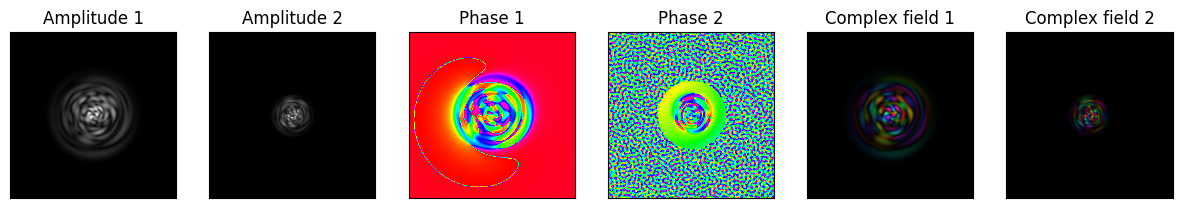

In [303]:
field = np.load('../imports/grin_speckle_example.npy')
# field = speckleret.transforms.pad_img(field, pad=2)
ft_field = speckleret.transforms.fourier_transform(field, pad=None)
_ = speckleret.plots.compare_complex_fields(field, ft_field, remove_ticks=True)

## Run phase retrieval on the computed fields

Let's first generate the support constraint from thresholding and visualize the support

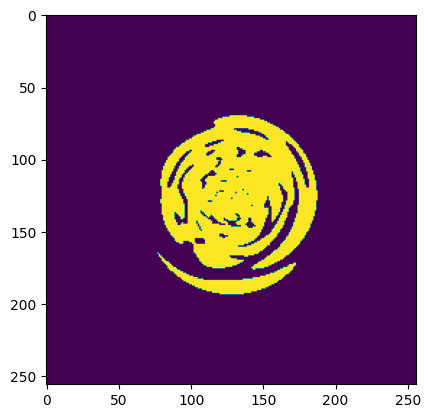

In [304]:
support = speckleret.supports.threshold_support(field, threshold=0.01)
plt.imshow(support)
plt.show()

# support = speckleret.supports.disk_support(field, radius=65)
# supported_field = field * support
# _ = speckleret.plots.complex_imshow(supported_field, remove_ticks=True)

## Run phase retrieval

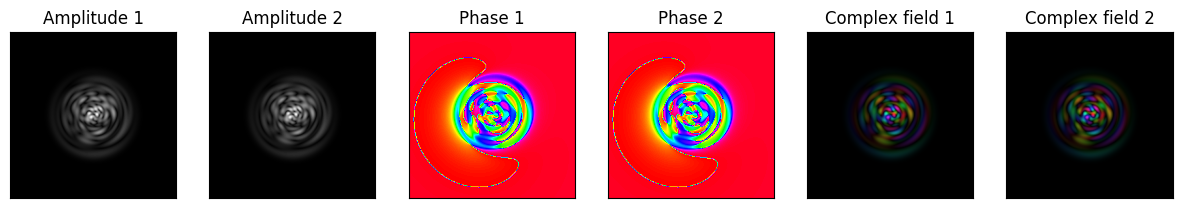

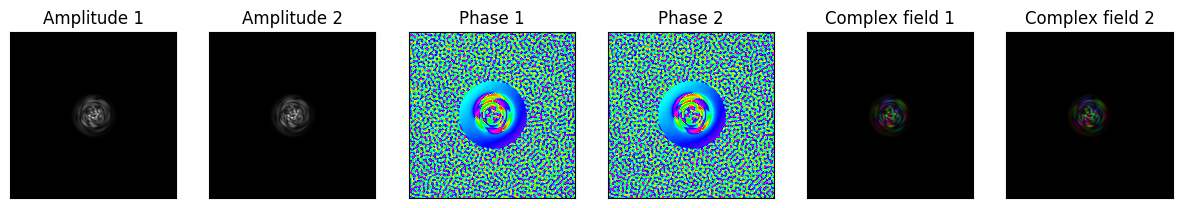

In [305]:
noisy_field = speckleret.noise.add_complex_noise(field, intens_noise_std=0.000, phase_noise_std=0*1064e-9/100, wavelength=1064e-9)
noisy_ft = speckleret.noise.add_complex_noise(ft_field, intens_noise_std=0.000, phase_noise_std=0*1064e-9/100, wavelength=1064e-9)

_ = speckleret.plots.compare_complex_fields(field, noisy_field, remove_ticks=True)
_ = speckleret.plots.compare_complex_fields(ft_field, noisy_ft, remove_ticks=True)

Quality: 0.985298014449119
Pearson: 0.9934162438629998
Best Quality: 0.9836817661115601
Best Pearson: 1.0000000000000002
Quality: 0.9731597600538188
Pearson: 0.9934162438629998
Best Quality: 0.9710386969651855
Best Pearson: 1.0000000000000002
Phase error:
  - Mean: -0.00000 rad
  - Std: 0.17168 rad
  - Lambda / X: 36.59906 rms


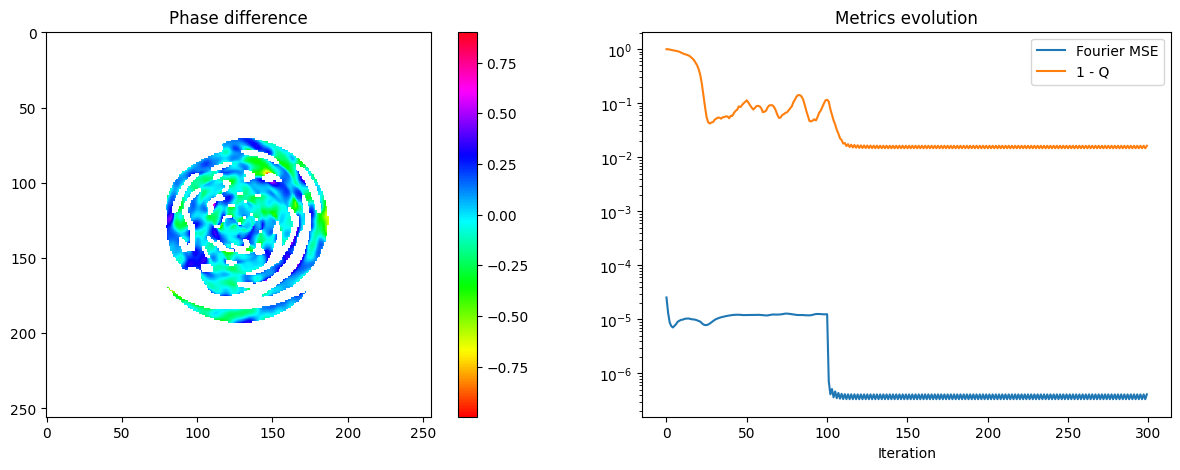

In [306]:
max_iter = 300
beta = 0.9

x = np.abs(noisy_field) * np.exp(1j * 2 * np.pi * np.random.rand(*field.shape))
x = cp.array(x)
noisy_field = cp.array(noisy_field)
noisy_ft = cp.array(noisy_ft)

mse = []
quality = []
for i in range(max_iter):
    metric = speckleret.cupy.metrics.mse(speckleret.cupy.transforms.fourier_transform(x), np.abs(noisy_ft))
    q = speckleret.cupy.metrics.quality(x[support], noisy_field[support], inversed=True)
    mse.append(metric)
    quality.append(q)

    if i < 100:
    # x = speckleret.retrievalmath.ER(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support)
    # 
        x = speckleret.cupy.retrievalmath.RAAR(x=x, magnitude_S=cp.abs(noisy_field), magnitude_M=cp.abs(noisy_ft), support=support, beta=beta)
    else:
        if i % 2 == 1:
            x = speckleret.retrievalmath.HIO(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support, beta=beta)
            # x = speckleret.retrievalmath.ER(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support)
        else:
            # x = speckleret.retrievalmath.ER(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support)
            x = speckleret.cupy.retrievalmath.RAAR(x=x, magnitude_S=cp.abs(noisy_field), magnitude_M=cp.abs(noisy_ft), support=support, beta=beta)
            x = speckleret.retrievalmath.ER(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support)
        

    if i == 0:
        q_best, x_best = q, x
    else:
        if q < q_best:
            q_best, x_best = q, x
            

x_best = cp.asnumpy(x_best)
noisy_field = cp.asnumpy(noisy_field)

print(f"Quality: {speckleret.metrics.quality(cp.asnumpy(x[support]), cp.asnumpy(noisy_field[support]))}")
print(f"Pearson: {speckleret.metrics.pearson(cp.asnumpy(x[support]), cp.asnumpy(noisy_field[support]))}")
print(f"Best Quality: {speckleret.metrics.quality(cp.asnumpy(x_best[support]), cp.asnumpy(noisy_field[support]))}")
print(f"Best Pearson: {speckleret.metrics.pearson(cp.asnumpy(x_best[support]), cp.asnumpy(noisy_field[support]))}")
print(f"Quality: {speckleret.metrics.quality(cp.asnumpy(np.exp(1j * np.angle(x[support]))), cp.asnumpy(np.exp(1j * np.angle(noisy_field[support]))))}")
print(f"Pearson: {speckleret.metrics.pearson(cp.asnumpy(x[support]), cp.asnumpy(noisy_field[support]))}")
print(f"Best Quality: {speckleret.metrics.quality(cp.asnumpy(np.exp(1j * np.angle(x_best[support]))), cp.asnumpy(np.exp(1j * np.angle(noisy_field[support]))))}")
print(f"Best Pearson: {speckleret.metrics.pearson(cp.asnumpy(x_best[support]), cp.asnumpy(noisy_field[support]))}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
speckleret.plots.phase_difference(cp.asnumpy(x_best), cp.asnumpy(noisy_field), support)

plt.subplot(1, 2, 2)
plt.plot([m.get() for m in mse], label='Fourier MSE')
plt.plot([q.get() for q in quality], label='1 - Q')
plt.yscale('log')
plt.title('Metrics evolution')
plt.xlabel('Iteration')
plt.legend()